In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shubhamshivendra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from bs4 import BeautifulSoup
from thefuzz import fuzz
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [18]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_feature_extraction.csv'):
    df = pd.read_csv("df_feature_extraction.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("df_feature_extraction.csv : run the previous notebook")

In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2> 4.3 Pre-processing of Text </h2>

- Preprocessing:
    - Removing html tags
    - Removing Date and Link with string
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [20]:
def pre_process(data):
    x = str(data).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")

    # Replacing Date with date string
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    x = re.sub(pattern, 'date', x)

    # Replacing links with link string
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    x = re.sub(pattern, 'link', x)

    #million and thousand representation
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)

    # Stemming
    porter = PorterStemmer()
    # Removing special chars
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)

    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()

    return x

<h3> 4.3.1 Advanced Feature Extraction (NLP and Fuzzy Features)  </h3>

In [21]:
def safe_divide(numerator, denominator, default=0):
    if denominator == 0:
        return default
    return 1.0 * (numerator / denominator)

In [25]:
def get_token_features(q1,q2):
    
    STOP_WORDS = stopwords.words("english")
    # creating list token_deatures

    token_features = [0.0]*10

    # token
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stopwords = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stopwords = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Feature Extraction NLP

    #1. CWC_MIN
    token_features[0] = safe_divide(len(q1_words & q2_words), min (len(q1_words), len(q2_words)))
    #2. CWC_MAX
    token_features[1] = safe_divide(len(q1_words & q2_words), max (len(q1_words), len(q2_words)))
    #3. CSC_MIN
    token_features[2] = safe_divide(len(q1_stopwords & q2_stopwords), min (len(q1_stopwords), len(q2_stopwords)))
    #4. CSC_MAX
    token_features[3] = safe_divide(len(q1_stopwords & q2_stopwords), max (len(q1_stopwords), len(q2_stopwords)))
    #5. CTC_MIN
    token_features[4] = safe_divide(len(set(q1_tokens) & set(q2_tokens)), min (len(q1_tokens), len(q2_tokens)))
    #6. CTC_MAX
    token_features[5] = safe_divide(len(set(q1_tokens) & set(q2_tokens)),max (len(q1_tokens), len(q2_tokens)))
    #7. last_word_eq
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    #8. first_word_eq
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    #9. abs_len_diff
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    #10. mean_len
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def feature_extraction(df):
    df["question1"] = df["question1"].fillna("").apply(pre_process)
    df["question2"] = df["question2"].fillna("").apply(pre_process)

    # Applying Feature

    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

    # Feature Extraction Fuzzy
    
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    #df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    return df

In [26]:
if os.path.isfile('DataSets/nlp_and_fuzzy_train.csv'):
    df = pd.read_csv("DataSets/nlp_and_fuzzy_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("DataSets/train.csv")
    df = feature_extraction(df)
    df.to_csv("DataSets/nlp_and_fuzzy_train.csv", index=False)
df.head(2)

Extracting features for train:


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1.0,0.833333,1.00,1.0,0.916667,0.785714,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.8,0.400000,0.75,0.6,0.700000,0.466667,0.0,1.0,5.0,12.5,86,63,66,78


<h3> 4.3.2 Analysis on Extracted Features  </h3>

<h4> 4.3.2.1 Plotting Word clouds </h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [121]:
# seperating duplicate and non duplicate data points
df_duplicate = df[df['is_duplicate'] == 1]
df_non_duplicate = df[df['is_duplicate'] == 0]

pos = (np.hstack([df_duplicate['question1'].values, df_duplicate['question2'].values]))
neg = (np.hstack([df_non_duplicate['question1'].values, df_non_duplicate['question2'].values]))

#Saving the np array into a text file
np.savetxt('train_pos.txt', pos, delimiter=' ', fmt='%s')
np.savetxt('train_neg.txt', neg, delimiter=' ', fmt='%s')

In [122]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_pos.txt'), encoding='ISO-8859-1' ).read()
textn_w = open(path.join(d, 'train_neg.txt'), encoding='ISO-8859-1').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110888
Total number of words in non duplicate pair questions : 33200399


<h5>Word Clouds generated from  duplicate pair question's text:</h5>

Word Cloud for Duplicate Question pairs


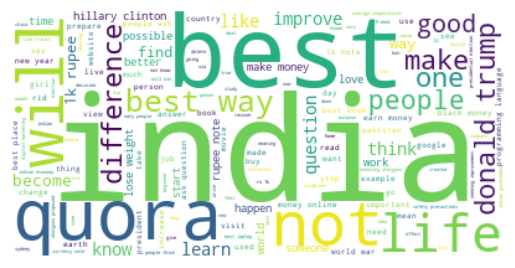

In [123]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h5>Word Clouds generated from Non-duplicates pair question's text:</h5>

Word Cloud for Non- duplicate Question pairs


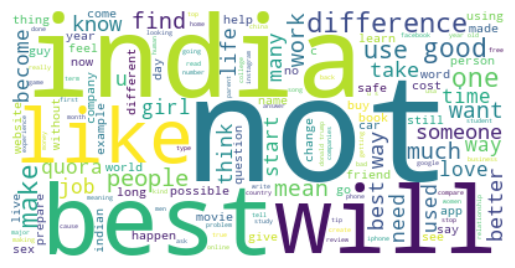

In [124]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non- duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<b>Observations</b>
1. India best, not occurs most of the time in both the datasets. 
2. quora, life occurrence is high in duplicate question pairs.
3. like, will occurs mostly in the non duplicate pairs.

<h4> 4.3.2.2 Plotting Pair plots for extracted features</h4>

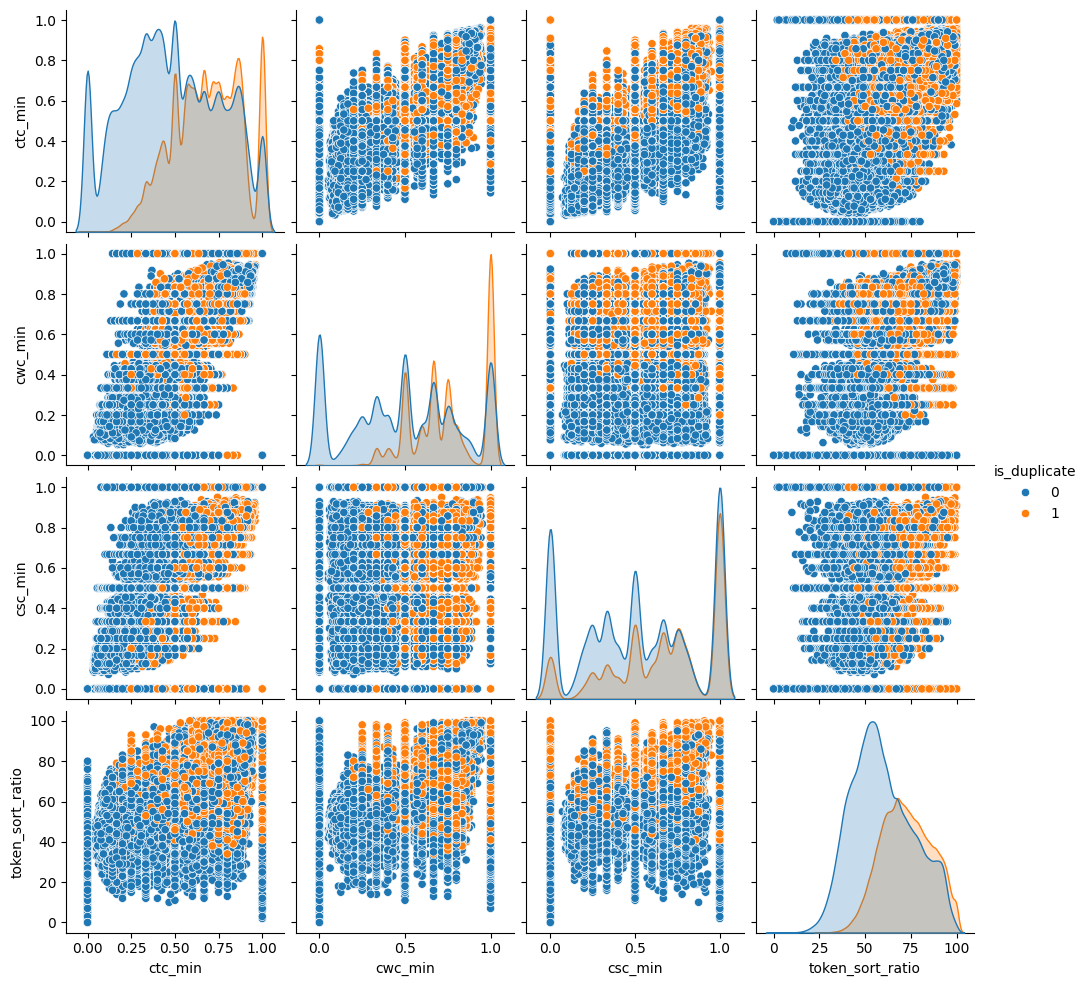

In [126]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<b>Observations:</b>
1. Token Sort ratio: there is an overlap for both the positive and negative points but all the negative data points lies below value <b>40</b> 
2. CWC_MIN: The value below <b>0.3</b> are all non duplicate pairs 
- Reason can be non duplicate pairs can have most of the words uncommon
3. CSC_MIN: There is fully overlapping case observed for this feature as both of the classes may have common stop words

Let's see the distribution of Token_sort_ratio

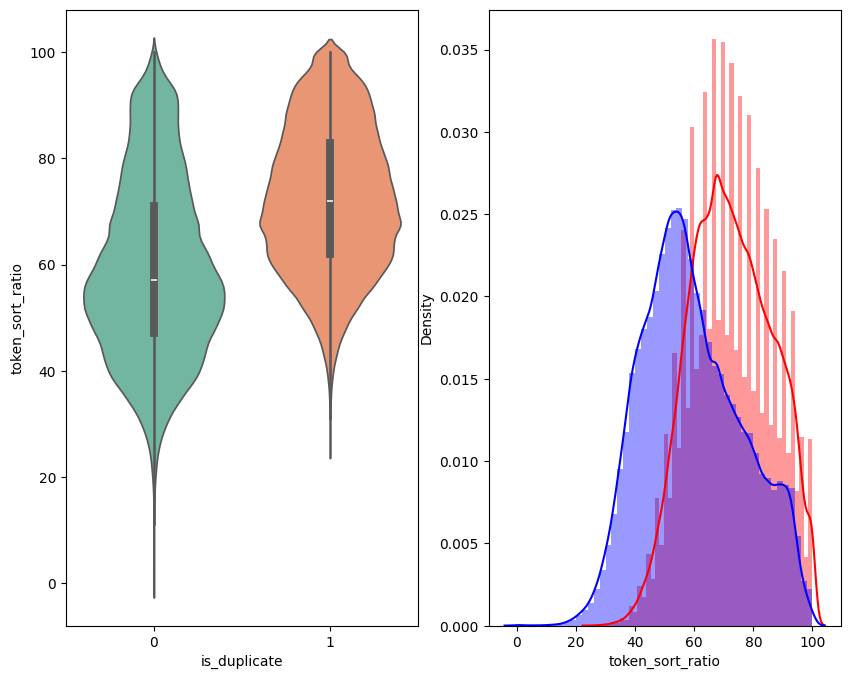

In [128]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , palette='Set2')

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<b> Observations</b>
1. Range: The token_sort_ratio ranges from about 20 to 100 for both groups, with a few lower outliers for non-duplicates.
Distribution shape:

2. Non-duplicates (0) have a bimodal distribution with peaks around 50 and 90.
Duplicates (1) have a right-skewed distribution with a strong peak near 100.


3. Central tendency: The median for duplicates is higher than for non-duplicates.
4. Spread: Duplicates have less spread (narrower IQR) compared to non-duplicates.
5. Density: There's a higher concentration of duplicates with very high token_sort_ratios (close to 100).

Let's see the distribution of Fuzz Ratio

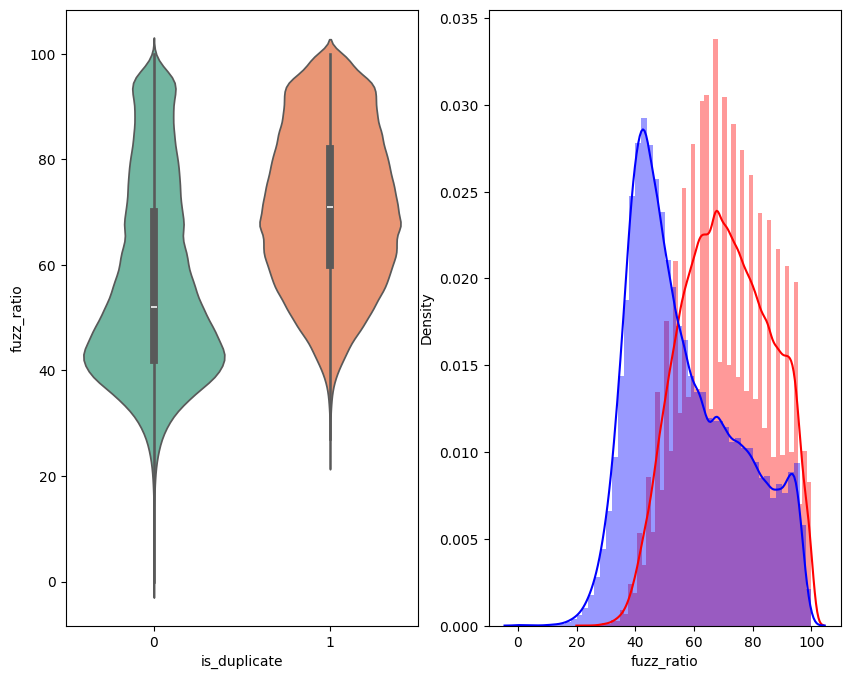

In [130]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , palette='Set2')

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<b>Observations:</b>



1. Non-duplicates (0): Bimodal distribution with strong peak near 40.

2. Duplicates (1): Having most of the datapoints between 60 - 80
3. Range: Both groups span approximately 20 to 100, with some lower outliers for non-duplicates.
4. Central tendency: The median (white dot) for duplicates is higher than for non-duplicates.
5. Spread: Duplicates show less spread (narrower interquartile range) compared to non-duplicates.
6. Density: Higher concentration of duplicates with very high token_sort_ratios (close to 100).



<h4> Since we have more than 15 features to explore We can use some dimensionality reduction techinques to analyse the data</h4>

- Implementing t-SNE

In [135]:
# Normalizing the feature using MinMax Scaler (TSNE uses euclidean distance to finalise the components)

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [136]:
# Reducing to two components (2D analysis)
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.112872
[t-SNE] Computed conditional probabilities in 0.114s
[t-SNE] Iteration 50: error = 85.2372131, gradient norm = 0.0907659 (50 iterations in 1.460s)
[t-SNE] Iteration 100: error = 70.5619659, gradient norm = 0.0139092 (50 iterations in 1.280s)
[t-SNE] Iteration 150: error = 68.4519348, gradient norm = 0.0079687 (50 iterations in 1.803s)
[t-SNE] Iteration 200: error = 67.3756256, gradient norm = 0.0054702 (50 iterations in 1.502s)
[t-SNE] Iteration 250: error = 66.8262787, gradient norm = 0.0046743

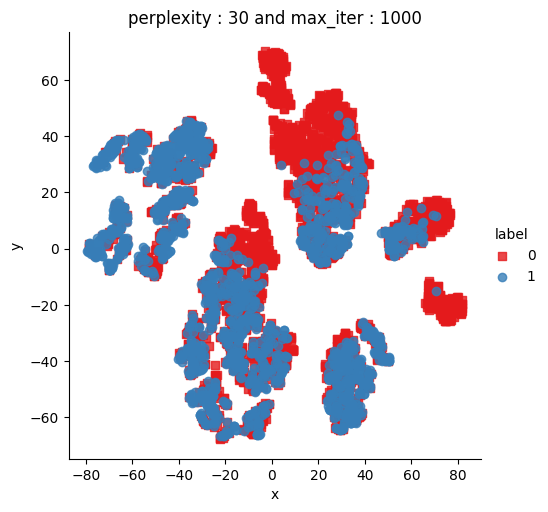

In [138]:
df_tsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne, x='x', y='y', hue='label', fit_reg=False,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [140]:
# Reducing to two components (3D analysis)
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.112872
[t-SNE] Computed conditional probabilities in 0.102s
[t-SNE] Iteration 50: error = 86.0364380, gradient norm = 0.0843706 (50 iterations in 2.480s)
[t-SNE] Iteration 100: error = 69.1502457, gradient norm = 0.0079074 (50 iterations in 2.124s)
[t-SNE] Iteration 150: error = 67.3757858, gradient norm = 0.0037482 (50 iterations in 1.965s)
[t-SNE] Iteration 200: error = 66.7395325, gradient norm = 0.0025875 (50 iterations in 1.809s)
[t-SNE] Iteration 250: error = 66.3865509, gradient norm = 0.0020378

In [142]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features', template = 'plotly_dark')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<b> Observations: </b>

1. 3D T-SNE have some seperations between duplicate and non-duplicate pairs 
2. Feature x below -10, y above 15 and z between 0 and -5 ave all non-duplicate points
